In [2]:
data_folder = "data/"
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["figure.figsize"] = (20,20)
import imageio
import numpy as np
from tqdm import tqdm
from random import choice, sample
import cv2

from enum import Enum

In [2]:
classes = ["Nucleoplasm",
"Nuclear membrane",
"Nucleoli",
"Nucleoli fibrillar center",
"Nuclear speckles",
"Nuclear bodies",
"Endoplasmic reticulum",
"Golgi apparatus",
"Intermediate filaments",
"Actin filaments",
"Microtubules",
"Mitotic spindle",
"Centrosome",
"Plasma membrane",
"Mitochondria",
"Aggresome",
"Cytosol",
"Vesicles and punctate cytosolic patterns",
"Negative"]

# Importing data

In [3]:
df = pd.read_csv(data_folder+"train.csv")

In [4]:
df

ID  Label
0      5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0  8|5|0
1      5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0   14|0
2      60b57878-bb99-11e8-b2b9-ac1f6b6435d0    6|1
3      5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0  16|10
4      5b931256-bb99-11e8-b2b9-ac1f6b6435d0   14|0
...                                     ...    ...
21801  dd0989c4-bbca-11e8-b2bc-ac1f6b6435d0     14
21802  dd1f7fb8-bbca-11e8-b2bc-ac1f6b6435d0    3|0
21803  dd5cb36a-bbca-11e8-b2bc-ac1f6b6435d0   14|0
21804  df573730-bbca-11e8-b2bc-ac1f6b6435d0     14
21805  dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0    5|0

[21806 rows x 2 columns]

# Filtering only monolabels

In [5]:
df = df[~df.Label.str.contains("\|")]

In [6]:
df

ID Label
5      5e22a522-bb99-11e8-b2b9-ac1f6b6435d0     0
6      5f79a114-bb99-11e8-b2b9-ac1f6b6435d0    14
9      5c801c04-bb99-11e8-b2b9-ac1f6b6435d0    14
10     5e9afd56-bb99-11e8-b2b9-ac1f6b6435d0     0
11     5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0     3
...                                     ...   ...
21798  d9d99186-bbca-11e8-b2bc-ac1f6b6435d0     3
21799  daa22470-bbca-11e8-b2bc-ac1f6b6435d0     0
21800  dc261180-bbca-11e8-b2bc-ac1f6b6435d0     6
21801  dd0989c4-bbca-11e8-b2bc-ac1f6b6435d0    14
21804  df573730-bbca-11e8-b2bc-ac1f6b6435d0    14

[10412 rows x 2 columns]

# Showing images

## Functions

In [7]:
class MaskType(Enum):
    CELL = "cell"
    NUCLEI = "nuclei"
    BOTH = "both"
    
maskcmap = ListedColormap([(1.,1.,1.), (1., 0., 0.), (0., 0., 1.)])
# finalcmap = ListedColormap([(1.,1.,1.), (1., 0., 0.), (0., 0., 1.), (0., 0., 1.), (0., 1., 0.)])
# explaination :
    # Nothing = White (0)
    # cell no green = red (1)
    # nuclei no green = blue (2)
    # nuclei no cell no green = blue (3, should not exist)
    # green = green (4 after clipping to 4)
    
def show_image(image: np.array, cmap: str = "Greens"):
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()
    
def show_green(_id: str, folder: str = "train/"):
    """
    Simply display the green chanel of an observation as aan image.
    """
    im = imageio.imread(data_folder+folder+_id+"_green.png")
    show_image(im)
    
def get_mask(_id: str, mask_type: MaskType = MaskType.CELL, binarize: bool = True):
    ret = np.load(f"{data_folder}hpa_{mask_type.value}_mask/{_id}.npz")["arr_0"]
    if binarize:
        return np.clip(ret, 0, 1)
    return ret

def get_masks(_id, binarize: bool = True):
    ret = np.load(f"{data_folder}hpa_cell_mask/{_id}.npz")["arr_0"], np.load(f"{data_folder}hpa_nuclei_mask/{_id}.npz")["arr_0"]
    if binarize:
        return np.clip(ret[0],0, 1), np.clip(ret[1], 0, 1)
    return ret

def show_mask(array: np.array, cmap: str = "Blues"):
    show_image(array, cmap)

    
def show_masks(_id):
    cell_array, nuclei_array = get_masks(_id)
    image = cell_array + nuclei_array
    print(f"Max={image.max()}, Min={image.min()}")
    print(f"Shape={image.shape}")
    plt.imshow(image, cmap=maskcmap)
    plt.axis('off')
    plt.show()

# def show_masks(_id):
#     cell_array, nuclei_array = get_masks(_id)
#     out_nuclei_cell = np.clip(cell_array - nuclei_array, 0, 1)
#     image =  1 - np.stack([out_nuclei_cell, np.ones_like(cell_array), nuclei_array], 2).astype(np.float)
#     print(f"Max={image.max()}, Min={image.min()}")
#     print(f"Shape={image.shape}")
#     plt.imshow(image)
#     plt.axis('off')
#     plt.show()
    
def show_organite(_id, folder: str = "train/"):
    cell_array, nuclei_array = get_masks(_id)
    out_nuclei_cell = np.clip(cell_array - nuclei_array, 0, 1)
    green = imageio.imread(data_folder+folder+_id+"_green.png").astype(np.uint16)
    blue = np.where(green==0, nuclei_array*255, 0).astype(np.uint16)
#     print(f"blue_min = {blue.min()}, blue_max = {blue.max()}")
    red = np.where(green==0, out_nuclei_cell*255, 0).astype(np.uint16)
    white = np.where(np.logical_and(green==0, np.logical_and(red==0, blue==0)), 255, 0).astype(np.uint16)

    blue += white
    red += white
    green += white
    
    final_im = np.stack([red, green, blue], 2)
    show_image(final_im)


## Showing Green channel

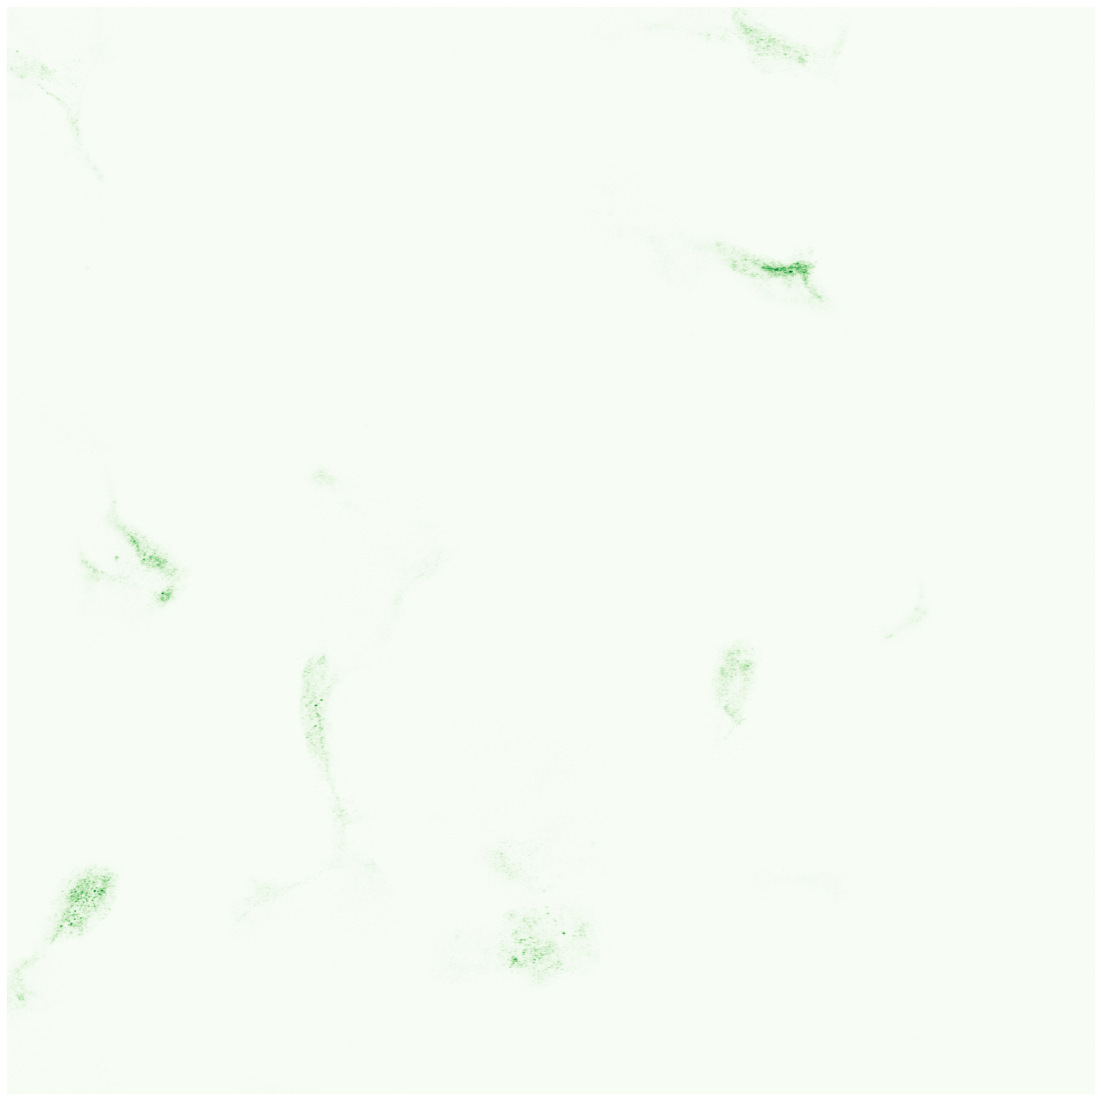

In [8]:
show_green("5e22a522-bb99-11e8-b2b9-ac1f6b6435d0")

# Showing masks

In [9]:
test_id = df.iloc[0,0]
test_id

'5e22a522-bb99-11e8-b2b9-ac1f6b6435d0'

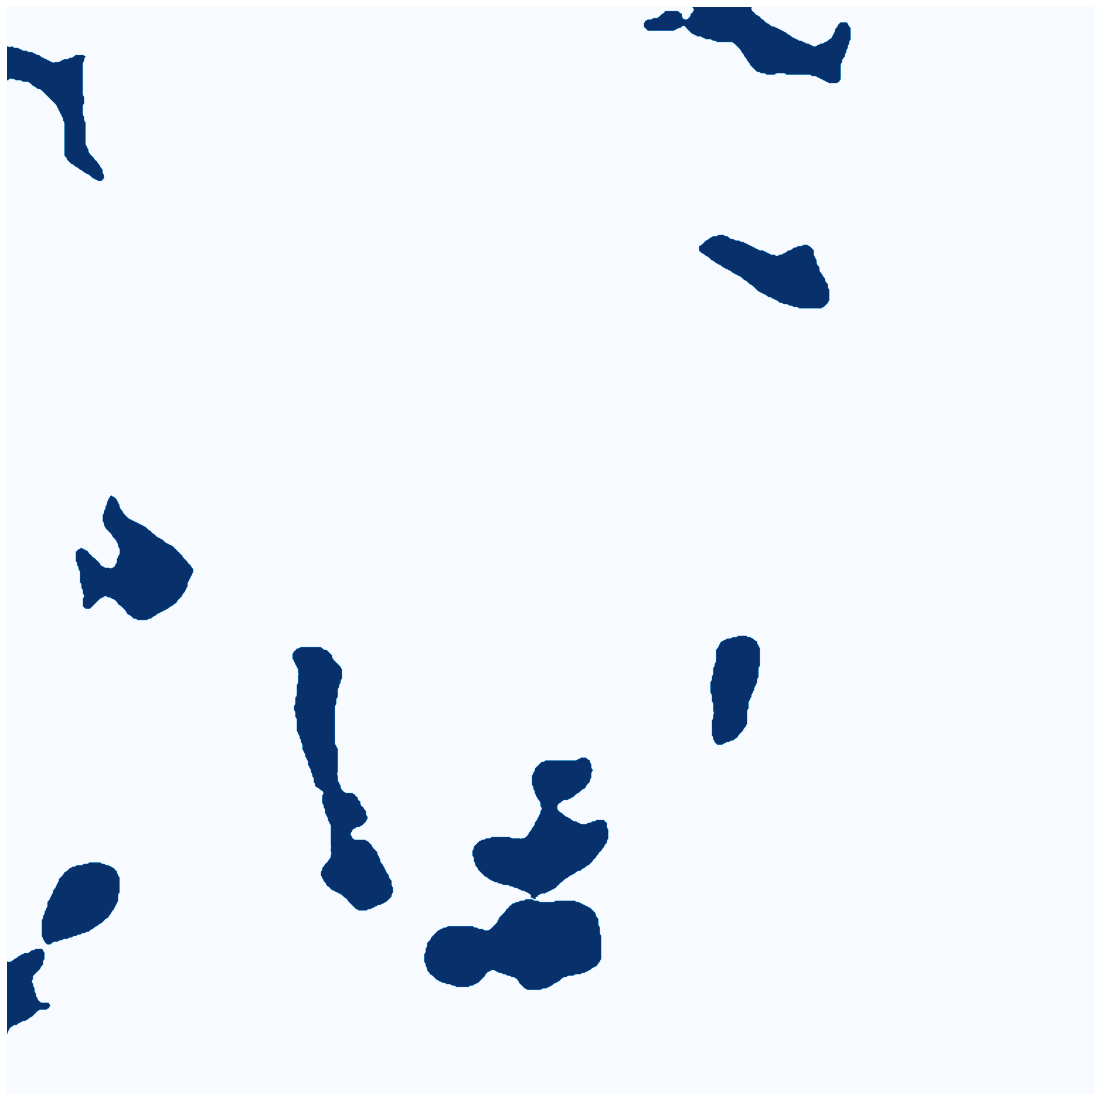

In [10]:
show_mask(get_mask(test_id, MaskType.CELL))

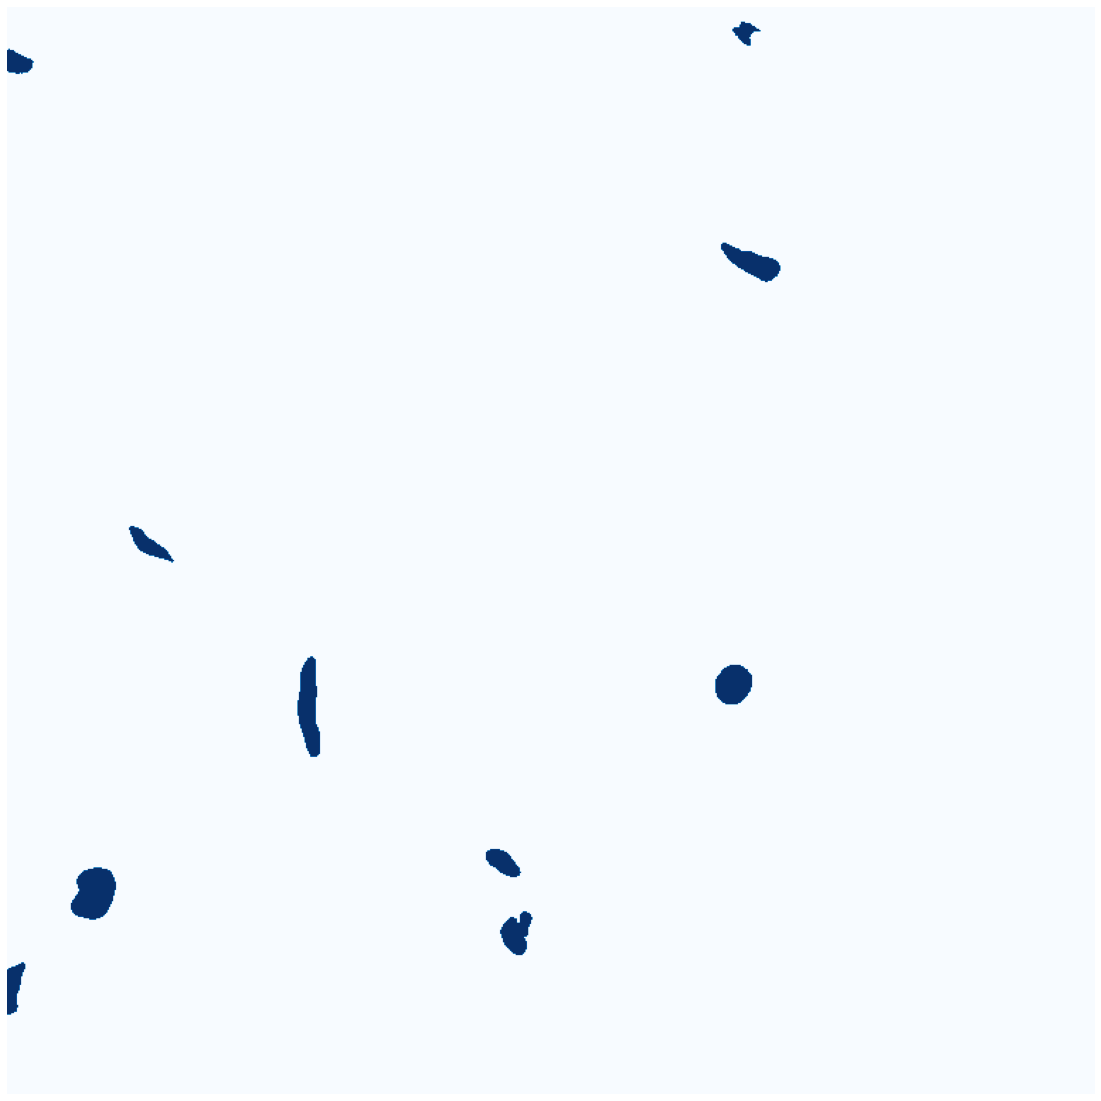

In [11]:
show_mask(get_mask(test_id, MaskType.NUCLEI))

Max=2, Min=0
Shape=(3072, 3072)


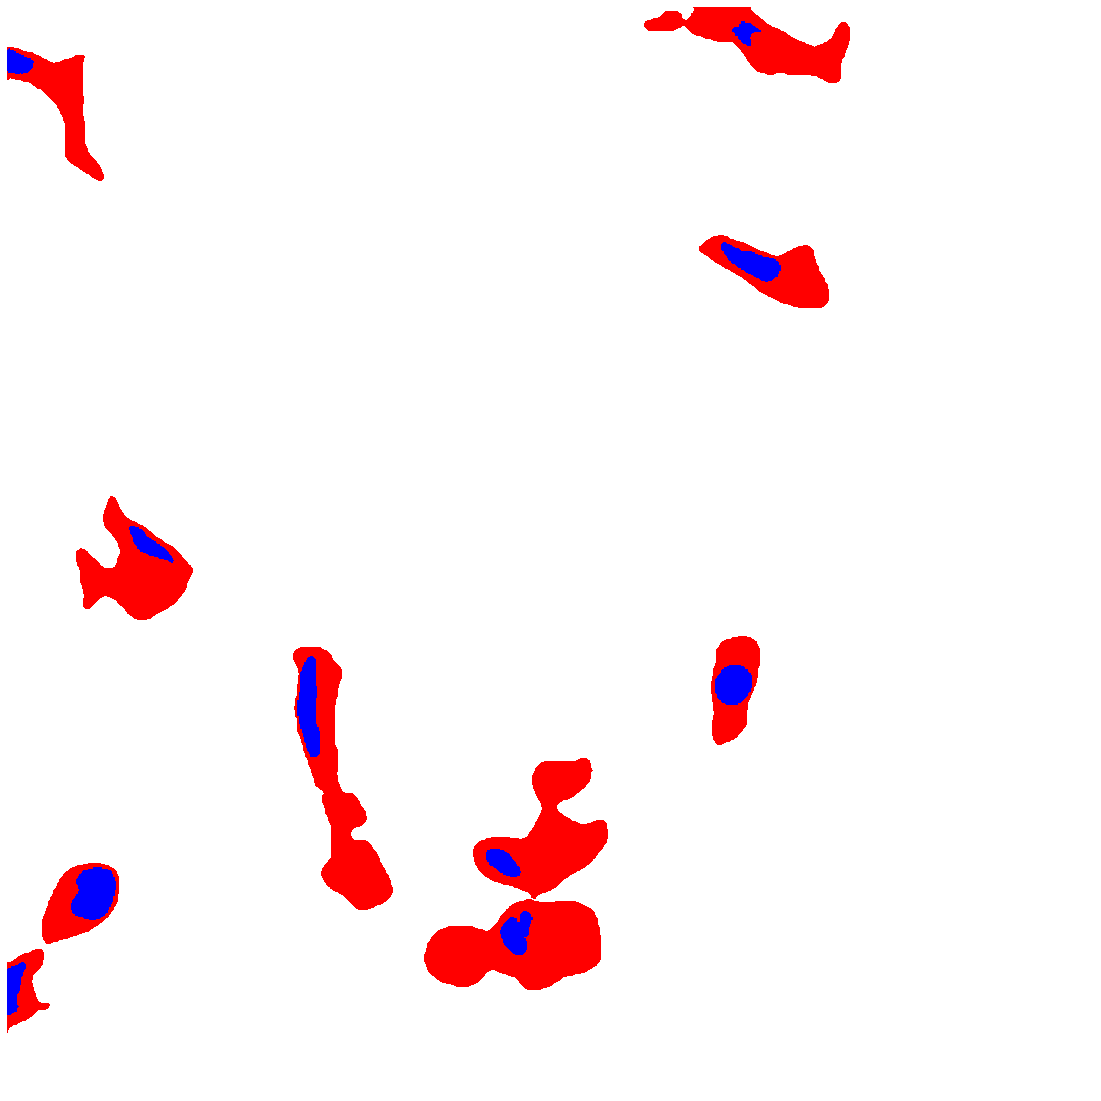

In [12]:
show_masks(test_id)

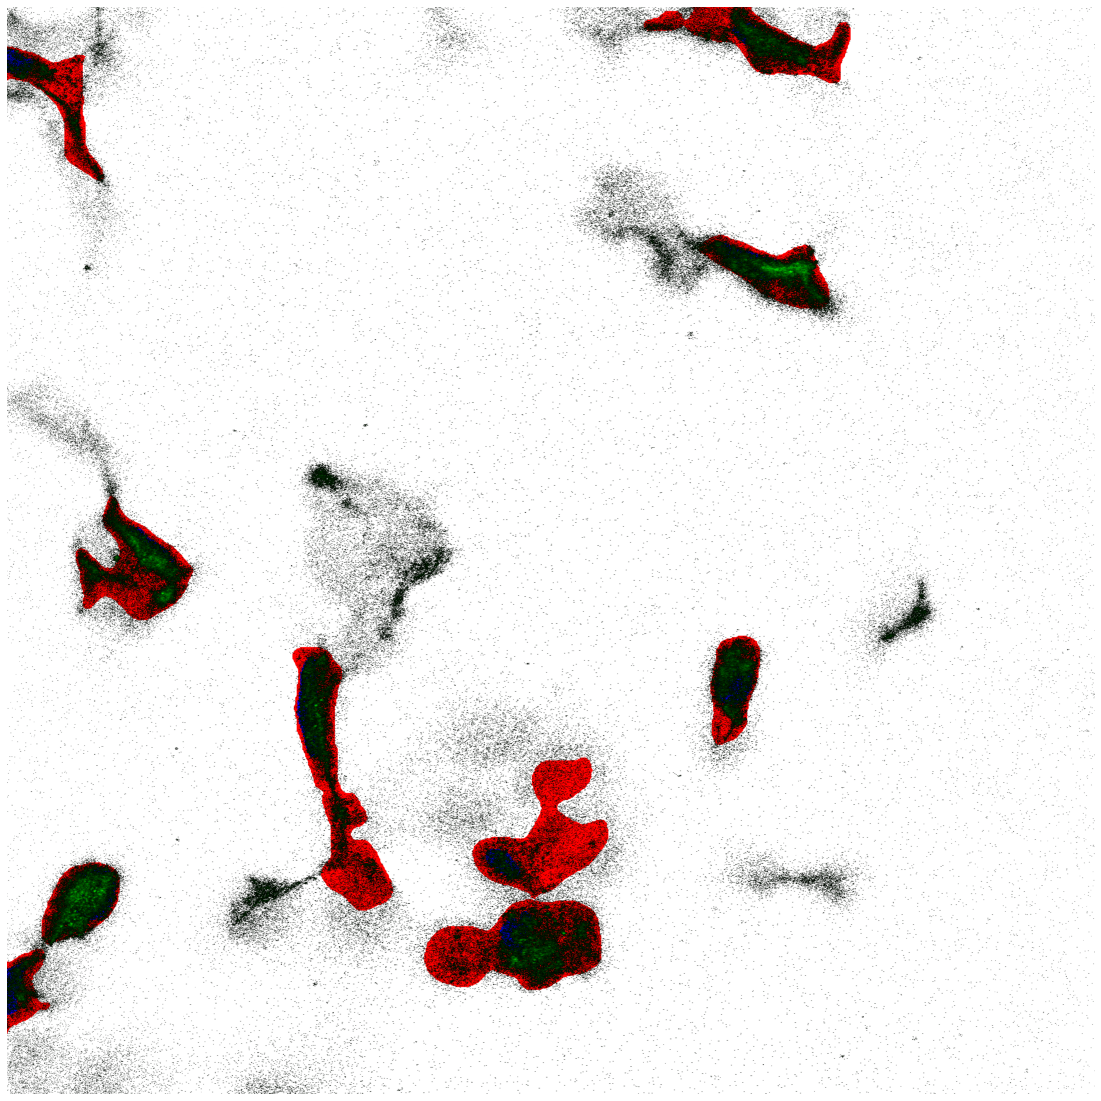

In [13]:
show_organite(test_id)

# Cropping images to individual cells

## Checking if any "nuclei" pixel is outside "cell"

In [286]:
nuc_is_outside_id = []
for _id in tqdm(df.ID):
    cell, nuc = get_masks(_id)
    if ((nuc-cell)<0).any():
        print(f"\"{_id}\" has a nucleus outside the cell.")
        nuc_is_outside_id.append(_id)

100%|██████████| 10412/10412 [13:04<00:00, 13.27it/s]


In [288]:
nuc_is_outside_id

[]

All  nuclei are inside cells.

## Cropping each cell

In [14]:
def is_iterable(obj):
    if isinstance(obj, str):
        return False
    try:
        iter_ = iter(obj)
        return True
    except Exception as e:
        return False

    
def bbox(arr):
    rows = np.any(arr, axis=1)
    cols = np.any(arr, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return [rmin, rmax, cmin, cmax]


def get_class_bbox(cells: np.array, class_idx: int, pads = None, padding: float = 0.01):
    """
    Padding is used only if pads is None. It will calculate the pads by the size of the image.
    """
    h, w = cells.shape
    if pads is None:
        pads = int(h * padding), int(w * padding)
    bb = bbox(cells==class_idx)
    bb[0] = max(bb[0] - pads[0], 0)
    bb[1] = min(bb[1] + pads[0], h)
    bb[2] = max(bb[2] - pads[1], 0)
    bb[3] = min(bb[3] + pads[1], w)
    return bb


def getall_bboxes(cells : np.array, padding: float = 0.01):
    pads = int(cells.shape[0] * padding), int(cells.shape[1] * padding)
    # bounding boxes
    bounding_boxes = []
    for i in range(1, cells.max()+1 ):
        bounding_boxes.append(get_class_bbox(cells, i, pads))
#         show_image((cells==i)[bb[0]:bb[1], bb[2]:bb[3]], "Blues")
    return bounding_boxes


def crop_array(array: np.array, bbox: list, filter_in : int = None):
    crop = array[bbox[0]:bbox[1], bbox[2]: bbox[3]]
    if filter_in:
        crop = np.where(crop == filter_in, crop, 0)
    return crop


## TODO : Factorize the two following function
def get_crops(_id, wipe_other_cells: bool = True, wipe_other_green: bool = False, for_visualisation: bool = True, show_images: bool = False):
    
    cell_array = np.load(f"{data_folder}hpa_cell_mask/{_id}.npz")["arr_0"]
    bboxes = getall_bboxes(cell_array)
    final_crops = []
    
    nuclei_array = np.load(f"{data_folder}hpa_nuclei_mask/{_id}.npz")["arr_0"]
    cell_no_nuclei_array = cell_array - nuclei_array
    
    green = imageio.imread(f"{data_folder}train/{_id}_green.png").astype(np.uint8)
    
    if for_visualisation:
        cell_array_filtered = np.where(green == 0, cell_no_nuclei_array, 0).astype(np.uint8)
        nuclei_array_filtered = np.where(green == 0, nuclei_array, 0).astype(np.uint8)
    
    
        for i, bbox in enumerate(bboxes):
            blue_crop = crop_array(nuclei_array_filtered, bbox, i+1 if wipe_other_cells else None)
            red_crop = crop_array(cell_array_filtered, bbox, i+1 if wipe_other_cells else None)
            green_crop = crop_array(green, bbox)

            if wipe_other_cells and wipe_other_green:
                total_cell_crop = crop_array(cell_array, bbox)
                green_crop = np.where(np.logical_and(total_cell_crop > 0, total_cell_crop != i+1), 0, green_crop)

            final_im = np.stack([red_crop*255, green_crop, blue_crop*255], 2)
            final_crops.append(final_im)
            if show_images:
                show_image(final_im)
    else:
        for i, bbox in enumerate(bboxes):
            blue_crop = crop_array(nuclei_array.astype(np.uint8), bbox, i+1 if wipe_other_cells else None)
            red_crop = crop_array(cell_no_nuclei_array.astype(np.uint8), bbox, i+1 if wipe_other_cells else None)
            green_crop = crop_array(green, bbox)
        
            if wipe_other_cells and wipe_other_green:
                total_cell_crop = crop_array(cell_array.astype(np.uint8), bbox)
                green_crop = np.where(np.logical_and(total_cell_crop > 0, total_cell_crop != i+1), 0, green_crop)
                
            final_im = np.stack([red_crop*255, green_crop, blue_crop*255], 2)
            final_crops.append(final_im)
            if show_images:
                show_image(final_im)


    return final_crops


def get_crop(_id, class_ids, wipe_other_cells: bool = True, wipe_other_green: bool = False, for_visualisation: bool = True, show_images: bool = False):
    
    if not is_iterable(class_ids):
        class_ids = [class_ids]
    
    cell_array = np.load(f"{data_folder}hpa_cell_mask/{_id}.npz")["arr_0"]
    bboxes = {idx: get_class_bbox(cell_array, idx) for idx in class_ids}
    final_crops = []
    
    nuclei_array = np.load(f"{data_folder}hpa_nuclei_mask/{_id}.npz")["arr_0"]
    cell_no_nuclei_array = cell_array - nuclei_array
    
    green = imageio.imread(f"{data_folder}train/{_id}_green.png").astype(np.uint8)
    
    if for_visualisation:
        cell_array_filtered = np.where(green == 0, cell_no_nuclei_array, 0).astype(np.uint8)
        nuclei_array_filtered = np.where(green == 0, nuclei_array, 0).astype(np.uint8)
    
    
        for class_idx, bbox in bboxes.items():
            blue_crop = crop_array(nuclei_array_filtered, bbox, class_idx if wipe_other_cells else None)
            red_crop = crop_array(cell_array_filtered, bbox, class_idx if wipe_other_cells else None)
            green_crop = crop_array(green, bbox)

            if wipe_other_cells and wipe_other_green:
                total_cell_crop = crop_array(cell_array, bbox)
                green_crop = np.where(np.logical_and(total_cell_crop > 0, total_cell_crop != class_idx), 0, green_crop)

            final_im = np.stack([red_crop*255, green_crop, blue_crop*255], 2)
            final_crops.append(final_im)
            if show_images:
                show_image(final_im)    
    else:
        for class_idx, bbox in bboxes.items():
            blue_crop = crop_array(nuclei_array.astype(np.uint8), bbox, class_idx if wipe_other_cells else None)
            red_crop = crop_array(cell_no_nuclei_array.astype(np.uint8), bbox, class_idx if wipe_other_cells else None)
            green_crop = crop_array(green, bbox)
        
            if wipe_other_cells and wipe_other_green:
                total_cell_crop = crop_array(cell_array.astype(np.uint8), bbox)
                green_crop = np.where(np.logical_and(total_cell_crop > 0, total_cell_crop != class_idx), 0, green_crop)
                
            final_im = np.stack([red_crop*255, green_crop, blue_crop*255], 2)
            final_crops.append(final_im)
            if show_images:
                show_image(final_im)


    return final_crops

In [25]:
cells = np.load(f"{data_folder}hpa_cell_mask/{test_id}.npz")["arr_0"]

In [26]:
get_crops(test_id, True, True)

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 4, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 

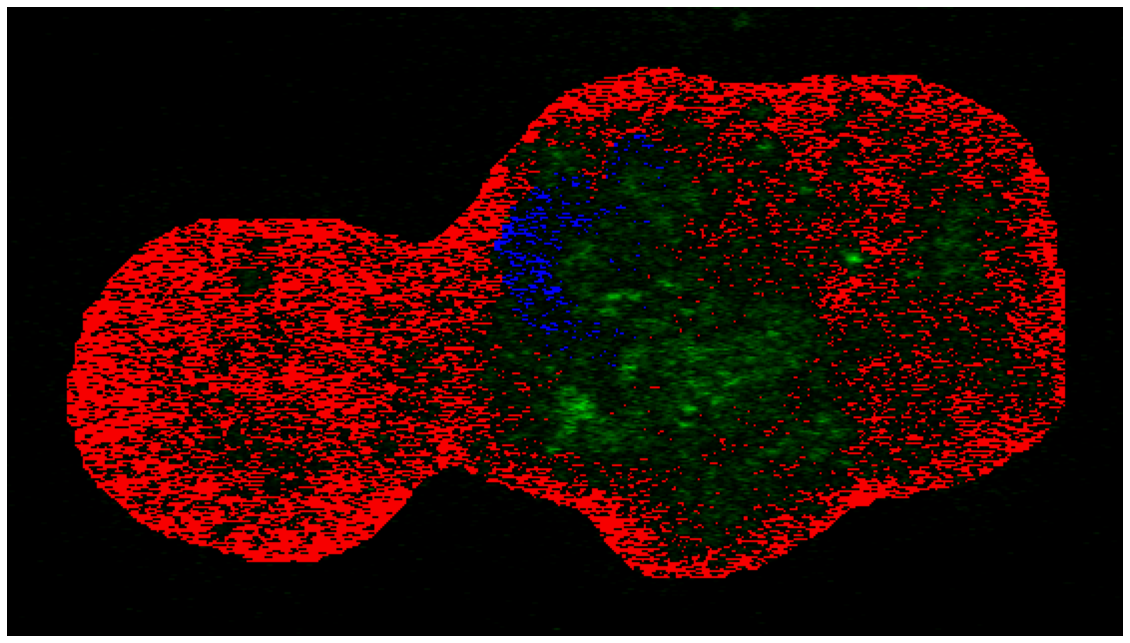

In [27]:
show_image(get_crops(test_id, wipe_other_cells=True)[8])

# Gathering each type of organite

In [35]:
preview = []
wiped_preview = []
wiped_green_preview = []
for c in sorted(map(int, df.Label.unique())):
    f_df = df[df.Label==str(c)]
    id_ = f_df.iloc[choice(range(len(f_df))), 0]
    
    crops = get_crops(id_, False)
    wiped_crops = get_crops(id_, True)
    wiped_green_crops = get_crops(id_, True, True)
    
    rand_crops_id = choice(range(len(crops)))
    
    preview.append(crops[rand_crops_id])
    wiped_preview.append(wiped_crops[rand_crops_id])
    wiped_green_preview.append(wiped_green_crops[rand_crops_id])

In [39]:
(wiped_crops[0] == wiped_green_crops[0]).all()

False

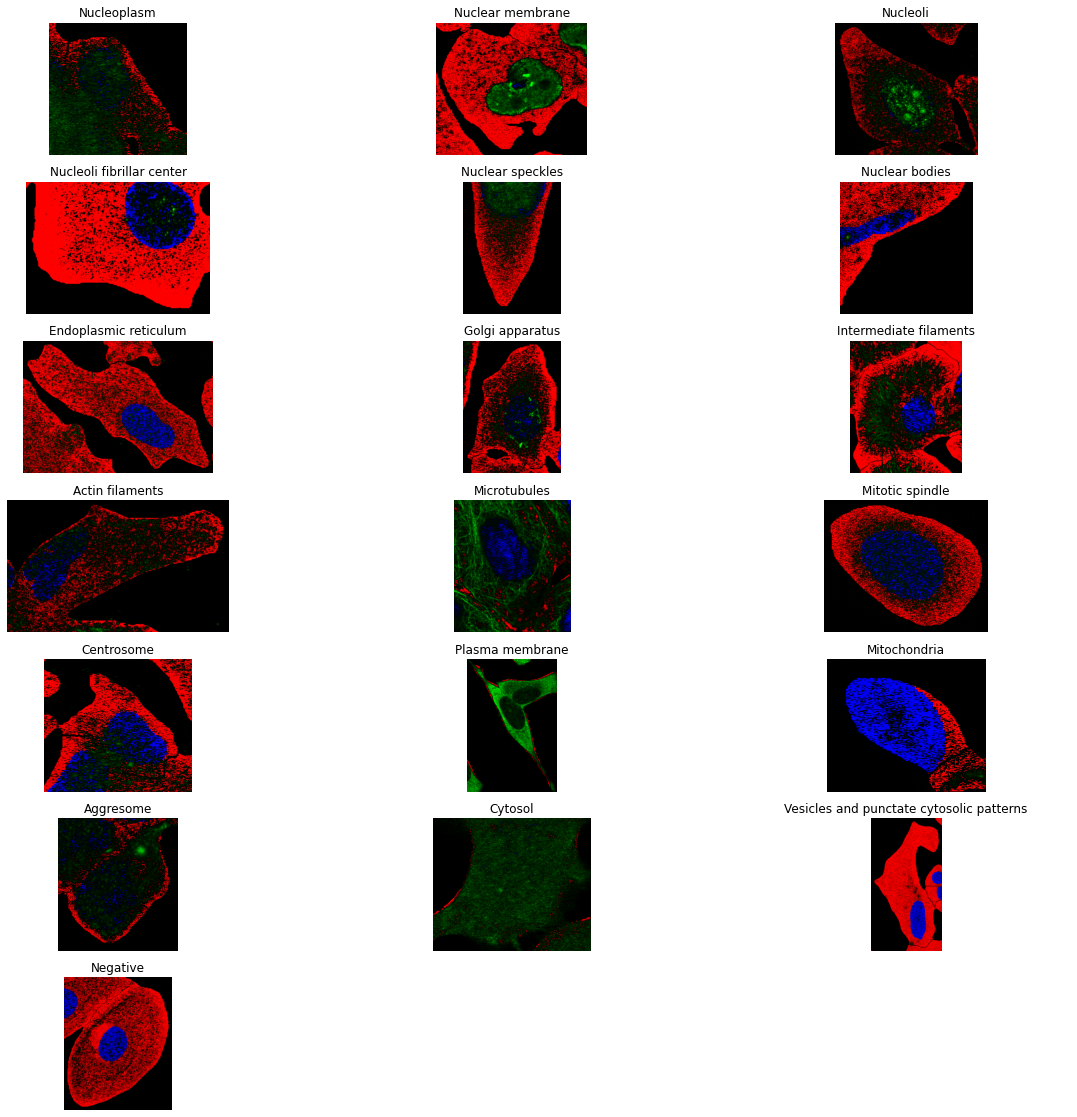

In [36]:
fig, axs = plt.subplots(7,3)
for i, ax in enumerate([ax for axy in axs for ax in axy]):
#     ax = axs[i//3, i%3]
    if i<len(preview):
        ax.imshow(preview[i])
        ax.set_title(classes[i])
    ax.grid(False)
    ax.axis(False)
plt.show()

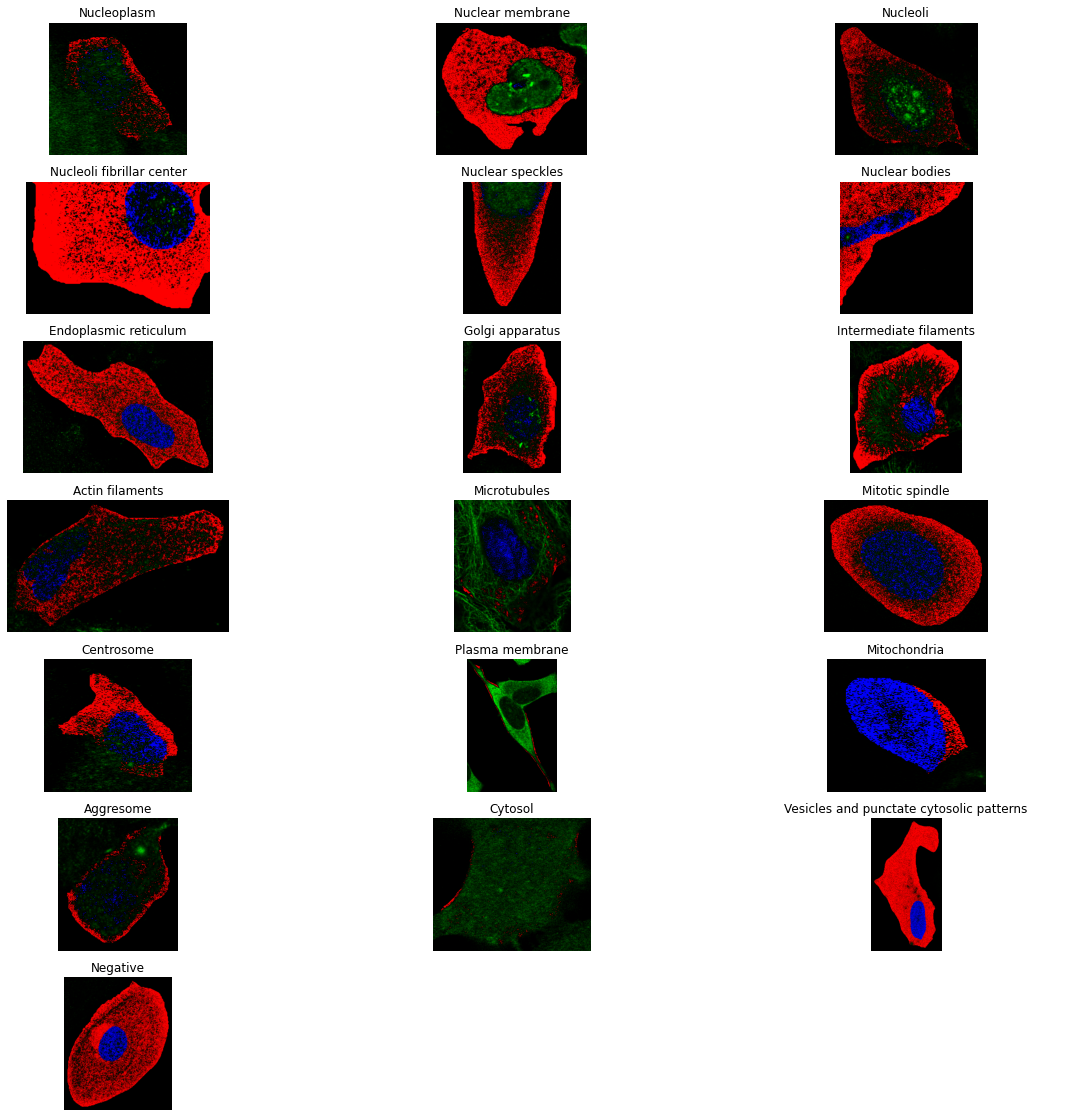

In [37]:
fig, axs = plt.subplots(7,3)
for i, ax in enumerate([ax for axy in axs for ax in axy]):
#     ax = axs[i//3, i%3]
    if i<len(wiped_preview):
        ax.imshow(wiped_preview[i])
        ax.set_title(classes[i])
    ax.grid(False)
    ax.axis(False)
plt.show()

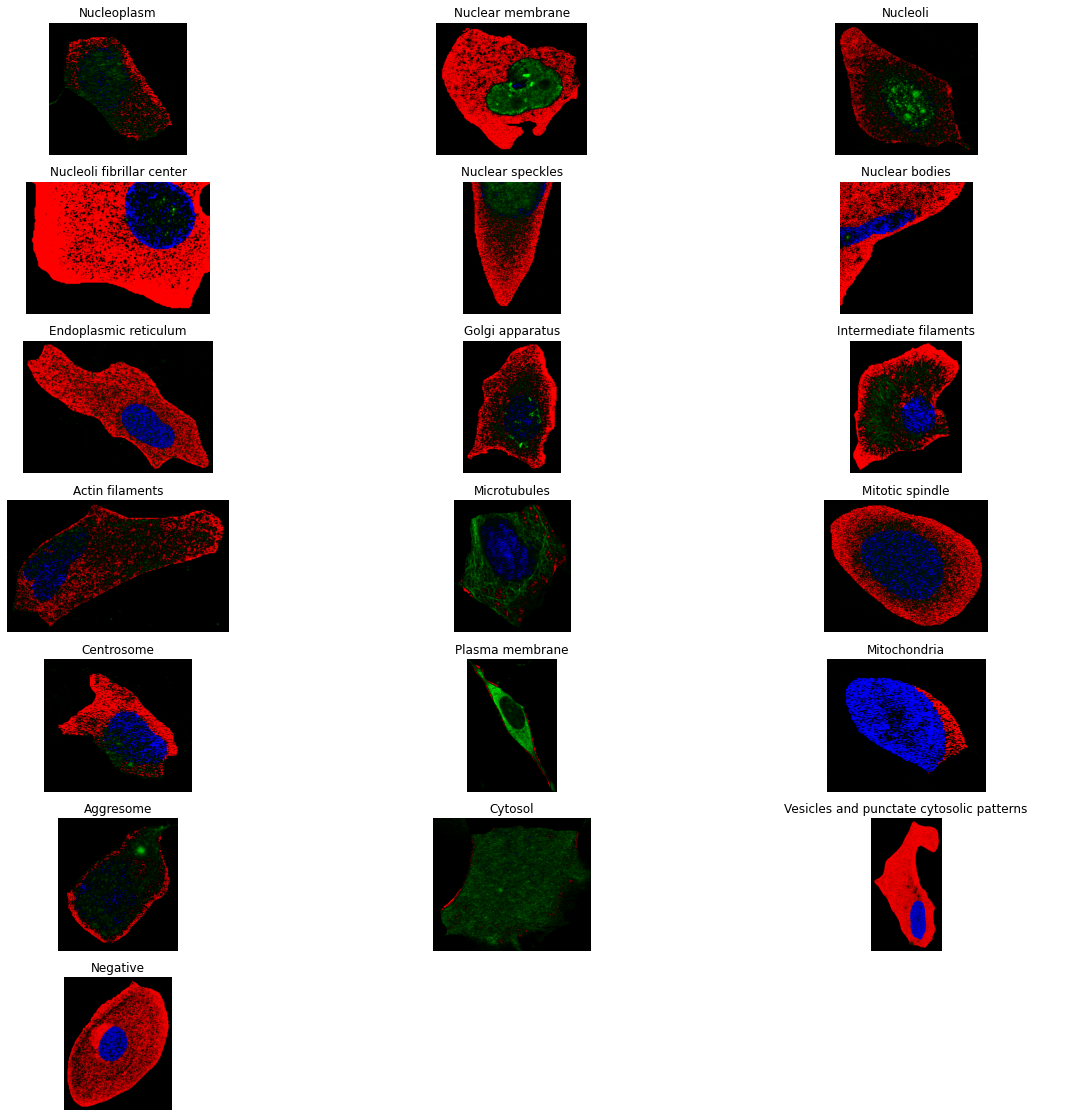

In [38]:
fig, axs = plt.subplots(7,3)
for i, ax in enumerate([ax for axy in axs for ax in axy]):
#     ax = axs[i//3, i%3]
    if i<len(wiped_preview):
        ax.imshow(wiped_green_preview[i])
        ax.set_title(classes[i])
    ax.grid(False)
    ax.axis(False)
plt.show()

## Not for visualisation (what will be fed to the CNN) :

In [67]:
preview = []
wiped_preview = []
wiped_green_preview = []
for c in sorted(map(int, df.Label.unique())):
    f_df = df[df.Label==str(c)]
    id_ = f_df.iloc[choice(range(len(f_df))), 0]
    
    crops = get_crops(id_, False, False, False)
    wiped_crops = get_crops(id_, True, False, False)
    wiped_green_crops = get_crops(id_, True, True, False)
    
    rand_crops_id = choice(range(len(crops)))
    
    preview.append(crops[rand_crops_id])
    wiped_preview.append(wiped_crops[rand_crops_id])
    wiped_green_preview.append(wiped_green_crops[rand_crops_id])

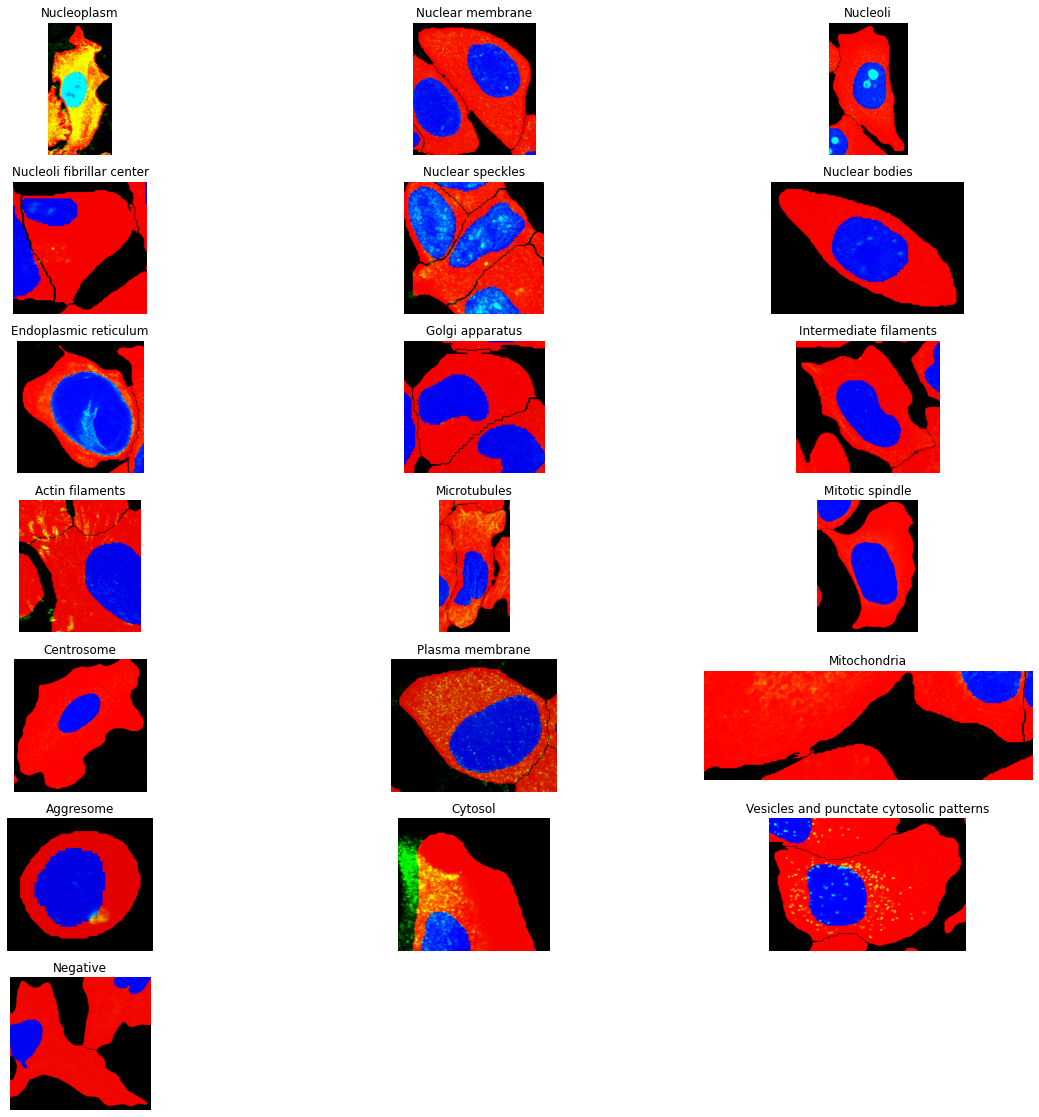

In [68]:
fig, axs = plt.subplots(7,3)
for i, ax in enumerate([ax for axy in axs for ax in axy]):
#     ax = axs[i//3, i%3]
    if i<len(preview):
        ax.imshow(preview[i])
        ax.set_title(classes[i])
    ax.grid(False)
    ax.axis(False)
plt.show()

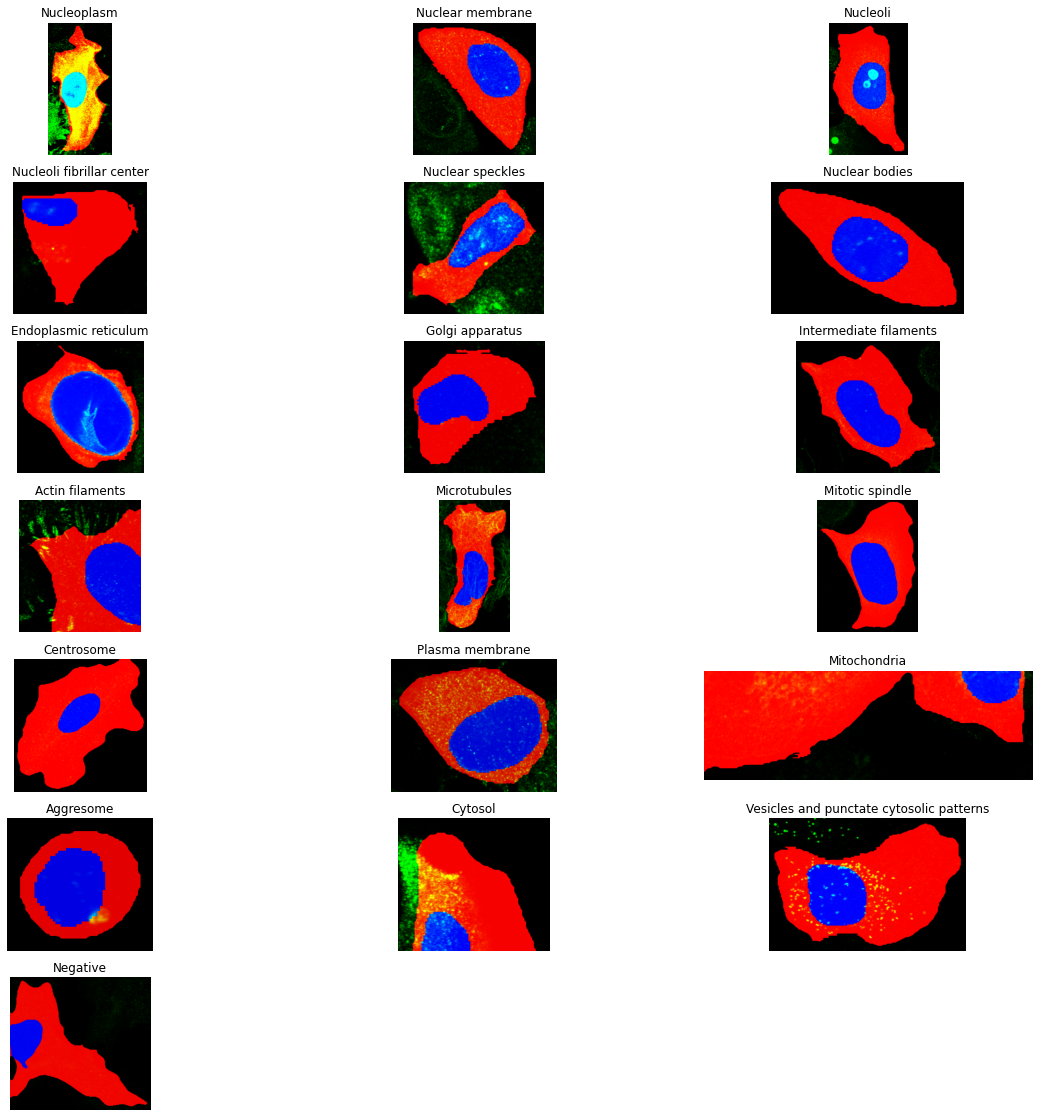

In [69]:
fig, axs = plt.subplots(7,3)
for i, ax in enumerate([ax for axy in axs for ax in axy]):
#     ax = axs[i//3, i%3]
    if i<len(wiped_preview):
        ax.imshow(wiped_preview[i])
        ax.set_title(classes[i])
    ax.grid(False)
    ax.axis(False)
plt.show()

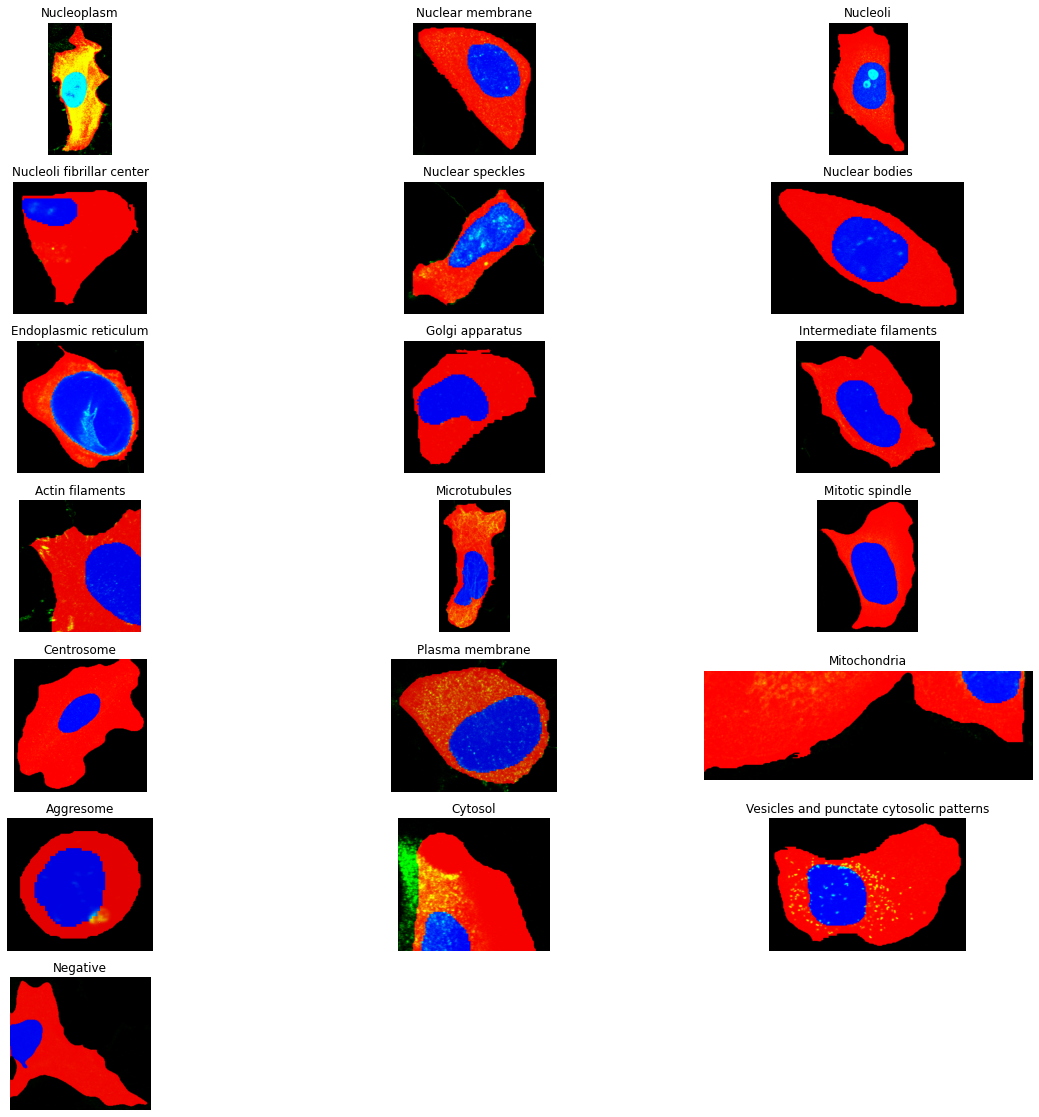

In [70]:
fig, axs = plt.subplots(7,3)
for i, ax in enumerate([ax for axy in axs for ax in axy]):
#     ax = axs[i//3, i%3]
    if i<len(wiped_preview):
        ax.imshow(wiped_green_preview[i])
        ax.set_title(classes[i])
    ax.grid(False)
    ax.axis(False)
plt.show()

## Several previews per class

In [ ]:
for i, cl in enumerate(classes):
    print(i, ":", cl.upper())
    fig, axs = plt.subplots(5, 5)
    ids_ = df[df.Label==str(i)]["ID"].values.tolist()
    obs_ids = sample(ids_, min(25, len(ids_)))
    cell_masks = {id_: choice(range(1, get_mask(id_, binarize=False).max() + 1)) for id_ in obs_ids}
    crops = [get_crop(id_, mask_id, True, True, True)[0] for id_, mask_id in cell_masks.items()]
    
    for i, ax in enumerate([ax for axy in axs for ax in axy]):
    #     ax = axs[i//3, i%3]
        if i < len(crops):
            ax.imshow(crops[i])
        ax.grid(False)
        ax.axis(False)
    plt.tight_layout()
    plt.suptitle(cl)
    plt.savefig(f'images/preview_per_cell/{cl}.png')
    plt.clf()

# Adding images and crop infos to dataset

In [157]:
def get_stats(arrays, names=None):
    if not is_iterable(arrays):
        arrays = [arrays]
        names = [names]
    return pd.DataFrame({names[i]: array for i, array in enumerate(arrays)}).describe()

In [75]:
crop_bboxes = []
crop_heights = []
crop_widths = []
image_heights = []
image_widths = []

for id_ in tqdm(df.ID):
    mask = get_mask(id_, MaskType.CELL, binarize=False)
    bboxes = getall_bboxes(mask, padding=0)
    
    h, w = mask.shape
    image_heights.append(h)
    image_widths.append(w)
    
    crop_bboxes.append(bboxes)
    crop_heights.append([bb[1] - bb[0] for bb in bboxes])
    crop_widths.append([bb[3] - bb[2] for bb in bboxes])
    
df["image_height"] = image_heights
df["image_width"] = image_widths
df["boxes_height"] = crop_heights
df["boxes_width"] = crop_widths
df["boxes"] = crop_bboxes

100%|██████████| 10412/10412 [18:50<00:00,  9.21it/s]
<ipython-input-75-7ea5a2672769>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["image_height"] = image_heights
<ipython-input-75-7ea5a2672769>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["image_width"] = image_widths
<ipython-input-75-7ea5a2672769>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [80]:
df.reset_index().rename(columns={"index": "old_index"})

old_index                                    ID Label  image_height  \
0              5  5e22a522-bb99-11e8-b2b9-ac1f6b6435d0     0          3072   
1              6  5f79a114-bb99-11e8-b2b9-ac1f6b6435d0    14          2048   
2              9  5c801c04-bb99-11e8-b2b9-ac1f6b6435d0    14          3072   
3             10  5e9afd56-bb99-11e8-b2b9-ac1f6b6435d0     0          2048   
4             11  5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0     3          2048   
...          ...                                   ...   ...           ...   
10407      21798  d9d99186-bbca-11e8-b2bc-ac1f6b6435d0     3          2048   
10408      21799  daa22470-bbca-11e8-b2bc-ac1f6b6435d0     0          2048   
10409      21800  dc261180-bbca-11e8-b2bc-ac1f6b6435d0     6          2048   
10410      21801  dd0989c4-bbca-11e8-b2bc-ac1f6b6435d0    14          2048   
10411      21804  df573730-bbca-11e8-b2bc-ac1f6b6435d0    14          3072   

       image_width                                       boxes_height  \
0             3072  [217, 379, 207, 351, 307, 743, 399, 231, 255, ...   
1             2048  [433, 599, 165, 558, 735, 771, 669, 583, 767, ...   
2             3072  [249, 285, 315, 335, 306, 399, 415, 289, 277, ...   
3             2048  [146, 261, 288, 368, 269, 211, 156, 208, 195, ...   
4             2048  [365, 525, 162, 273, 279, 323, 469, 310, 316, ...   
...            ...                                                ...   
10407         2048  [845, 173, 299, 455, 587, 1127, 659, 811, 395,...   
10408         2048               [1149, 909, 439, 623, 940, 721, 625]   
10409         2048  [165, 288, 329, 275, 260, 259, 358, 431, 387, ...   
10410         2048  [357, 325, 425, 345, 515, 527, 251, 424, 343, ...   
10411         3072  [173, 281, 957, 84, 365, 337, 975, 404, 479, 6...   

                                             boxes_width  \
0      [583, 273, 367, 331, 139, 283, 383, 219, 499, ...   
1      [605, 606, 699, 609, 617, 447, 452, 469, 610, ...   
2      [331, 543, 537, 339, 275, 195, 319, 137, 276, ...   
3      [205, 209, 283, 129, 231, 179, 210, 162, 126, ...   
4      [884, 415, 582, 708, 485, 429, 557, 286, 475, ...   
...                                                  ...   
10407  [1093, 607, 437, 655, 741, 387, 483, 265, 422,...   
10408               [463, 815, 735, 1057, 536, 223, 451]   
10409  [378, 182, 291, 411, 266, 157, 259, 291, 365, ...   
10410  [399, 512, 591, 695, 461, 437, 333, 507, 615, ...   
10411  [968, 681, 803, 115, 308, 534, 347, 620, 319, ...   

                                                   boxes  
0      [[0, 217, 1798, 2381], [114, 493, 0, 273], [64...  
1      [[0, 433, 0, 605], [0, 599, 568, 1174], [0, 16...  
2      [[0, 249, 42, 373], [0, 285, 1894, 2437], [226...  
3      [[0, 146, 455, 660], [0, 261, 635, 844], [5, 2...  
4      [[0, 365, 0, 884], [0, 525, 766, 1181], [0, 16...  
...                                                  ...  
10407  [[0, 845, 0, 1093], [0, 173, 1122, 1729], [70,...  
10408  [[0, 1149, 370, 833], [0, 909, 666, 1481], [75...  
10409  [[0, 165, 78, 456], [0, 288, 459, 641], [0, 32...  
10410  [[0, 357, 0, 399], [0, 325, 249, 761], [0, 425...  
10411  [[0, 173, 0, 968], [0, 281, 779, 1460], [0, 95...  

[10412 rows x 8 columns]

In [81]:
df.reset_index().rename(columns={"index": "old_index"}).to_csv("data/train_bboxes.csv")

In [86]:
df_b = pd.read_csv("data/train_bboxes.csv", index_col=0)

In [87]:
df_b

old_index                                    ID  Label  image_height  \
0              5  5e22a522-bb99-11e8-b2b9-ac1f6b6435d0      0          3072   
1              6  5f79a114-bb99-11e8-b2b9-ac1f6b6435d0     14          2048   
2              9  5c801c04-bb99-11e8-b2b9-ac1f6b6435d0     14          3072   
3             10  5e9afd56-bb99-11e8-b2b9-ac1f6b6435d0      0          2048   
4             11  5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0      3          2048   
...          ...                                   ...    ...           ...   
10407      21798  d9d99186-bbca-11e8-b2bc-ac1f6b6435d0      3          2048   
10408      21799  daa22470-bbca-11e8-b2bc-ac1f6b6435d0      0          2048   
10409      21800  dc261180-bbca-11e8-b2bc-ac1f6b6435d0      6          2048   
10410      21801  dd0989c4-bbca-11e8-b2bc-ac1f6b6435d0     14          2048   
10411      21804  df573730-bbca-11e8-b2bc-ac1f6b6435d0     14          3072   

       image_width                                       boxes_height  \
0             3072  [217, 379, 207, 351, 307, 743, 399, 231, 255, ...   
1             2048  [433, 599, 165, 558, 735, 771, 669, 583, 767, ...   
2             3072  [249, 285, 315, 335, 306, 399, 415, 289, 277, ...   
3             2048  [146, 261, 288, 368, 269, 211, 156, 208, 195, ...   
4             2048  [365, 525, 162, 273, 279, 323, 469, 310, 316, ...   
...            ...                                                ...   
10407         2048  [845, 173, 299, 455, 587, 1127, 659, 811, 395,...   
10408         2048               [1149, 909, 439, 623, 940, 721, 625]   
10409         2048  [165, 288, 329, 275, 260, 259, 358, 431, 387, ...   
10410         2048  [357, 325, 425, 345, 515, 527, 251, 424, 343, ...   
10411         3072  [173, 281, 957, 84, 365, 337, 975, 404, 479, 6...   

                                             boxes_width  \
0      [583, 273, 367, 331, 139, 283, 383, 219, 499, ...   
1      [605, 606, 699, 609, 617, 447, 452, 469, 610, ...   
2      [331, 543, 537, 339, 275, 195, 319, 137, 276, ...   
3      [205, 209, 283, 129, 231, 179, 210, 162, 126, ...   
4      [884, 415, 582, 708, 485, 429, 557, 286, 475, ...   
...                                                  ...   
10407  [1093, 607, 437, 655, 741, 387, 483, 265, 422,...   
10408               [463, 815, 735, 1057, 536, 223, 451]   
10409  [378, 182, 291, 411, 266, 157, 259, 291, 365, ...   
10410  [399, 512, 591, 695, 461, 437, 333, 507, 615, ...   
10411  [968, 681, 803, 115, 308, 534, 347, 620, 319, ...   

                                                   boxes  
0      [[0, 217, 1798, 2381], [114, 493, 0, 273], [64...  
1      [[0, 433, 0, 605], [0, 599, 568, 1174], [0, 16...  
2      [[0, 249, 42, 373], [0, 285, 1894, 2437], [226...  
3      [[0, 146, 455, 660], [0, 261, 635, 844], [5, 2...  
4      [[0, 365, 0, 884], [0, 525, 766, 1181], [0, 16...  
...                                                  ...  
10407  [[0, 845, 0, 1093], [0, 173, 1122, 1729], [70,...  
10408  [[0, 1149, 370, 833], [0, 909, 666, 1481], [75...  
10409  [[0, 165, 78, 456], [0, 288, 459, 641], [0, 32...  
10410  [[0, 357, 0, 399], [0, 325, 249, 761], [0, 425...  
10411  [[0, 173, 0, 968], [0, 281, 779, 1460], [0, 95...  

[10412 rows x 8 columns]

In [166]:
df_b.boxes_height.apply(eval).apply(np.size).describe()

count    10412.000000
mean        23.844698
std         13.871170
min          0.000000
25%         14.000000
50%         20.000000
75%         30.250000
max        116.000000
Name: boxes_height, dtype: float64

In [96]:
heights = df_b.boxes_height.apply(eval).sum()
widths = df_b.boxes_width.apply(eval).sum()

In [173]:
for s in (368,400):
    print(f"Count of negative resizings for size {s} = {((np.array(heights)>s)|(np.array(widths)>s)).sum()}")

Count of negative resizings for size 368 = 159100
Count of negative resizings for size 400 = 142912


In [154]:
pd.DataFrame({"height": heights, "widht": widths})

height  widht
0          217    583
1          379    273
2          207    367
3          351    331
4          307    139
...        ...    ...
248266     537    953
248267     351    397
248268     271    291
248269     189    395
248270     161    355

[248271 rows x 2 columns]

In [156]:
get_stats((heights, widths), ["Height", "Width"])

Height          Width
count  248271.000000  248271.000000
mean      405.671178     410.887583
std       208.133892     210.459873
min        31.000000      29.000000
25%       256.000000     260.000000
50%       363.000000     367.000000
75%       512.000000     518.000000
max      2709.000000    2839.000000

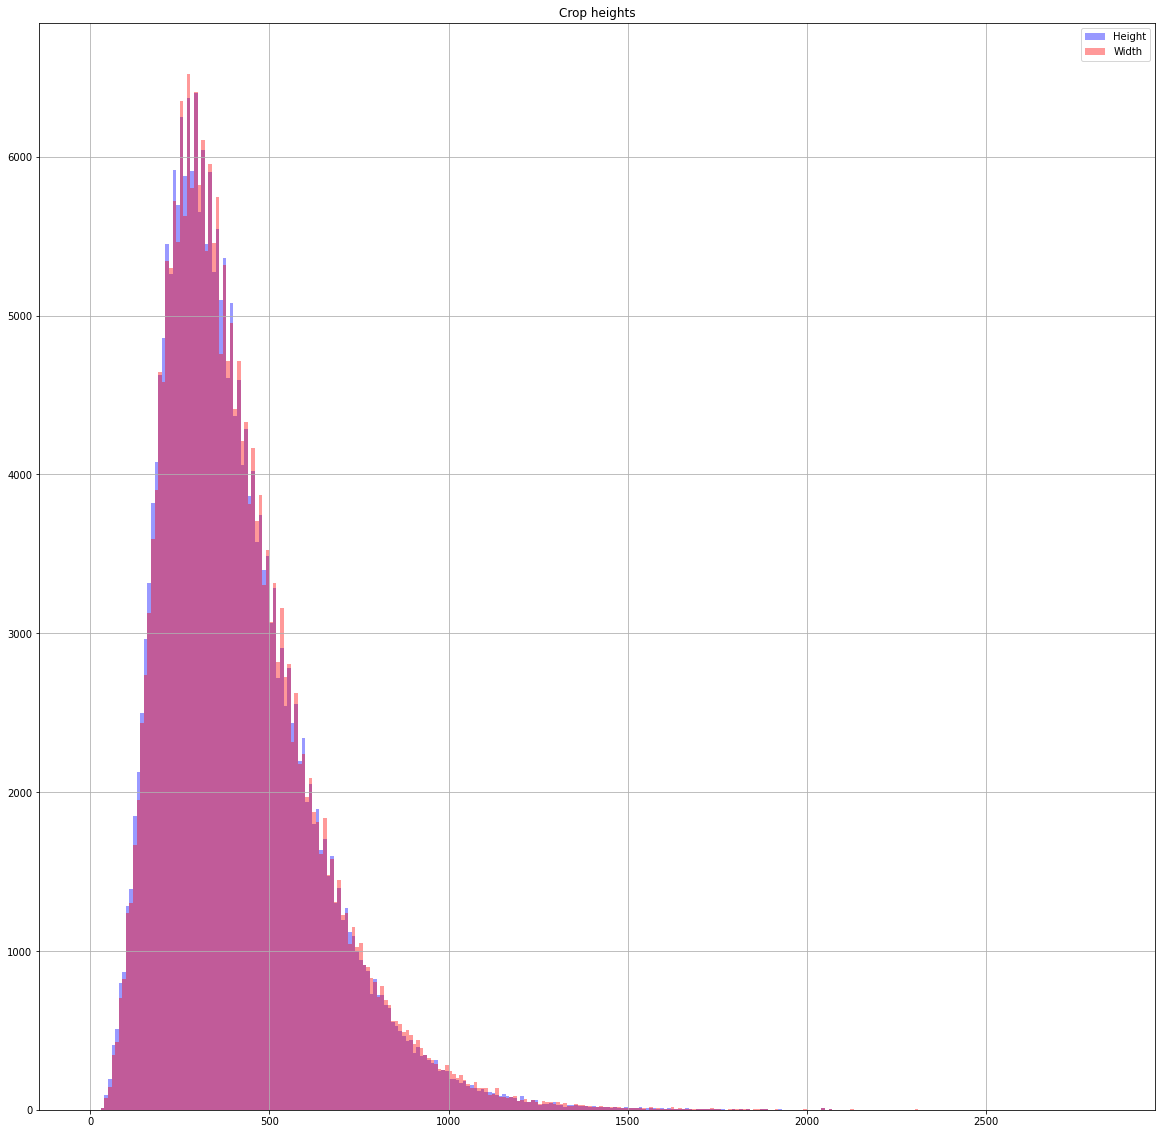

In [117]:
plt.hist(heights, bins=np.arange(0, max(heights)+1, 10), color="blue", alpha=0.4)
plt.hist(widths, bins=np.arange(0, max(widths)+1, 10), color="red", alpha=0.4)
plt.legend(["Height", "Width"])
plt.title("Crop heights")
plt.grid()
plt.show()

# Resizing crops

In [175]:
np.array([1,10])>np.array([2,8])

array([False,  True])

In [179]:
np.zeros((5,5))

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [9]:
def resize_down(crop: np.array, size: int):
    return cv2.resize(crop, (size, size), interpolation=cv2.INTER_AREA)


def add_margins(crop: np.array, size: int):
    ret = np.zeros((size, size, crop.shape[2]))
    h, w = crop.shape[:2]
    dy, dx = (size - h) // 2, (size - w) // 2
    ret[dy : dy + h, dx : dx + w, :] = crop
    return ret


def resize_crop(crop: np.array, size: int):
    if max(crop.shape[:2]) == size:
        return crop
    if (np.array(crop.shape[:2]) > size).any():
        return resize_down(crop, size)
    else:
        return add_margins(crop, size)
        

In [251]:
wiped_green_preview_resized = []
for c in sorted(map(int, df.Label.unique())):
    f_df = df[df.Label==str(c)]
    id_ = f_df.iloc[choice(range(len(f_df))), 0]
    
    wiped_green_crops = get_crops(id_, True, True, False)
    
    rand_crops_id = choice(range(len(wiped_green_crops)))
    
    wiped_green_preview_resized.append(resize_crop(wiped_green_crops[rand_crops_id], 410))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


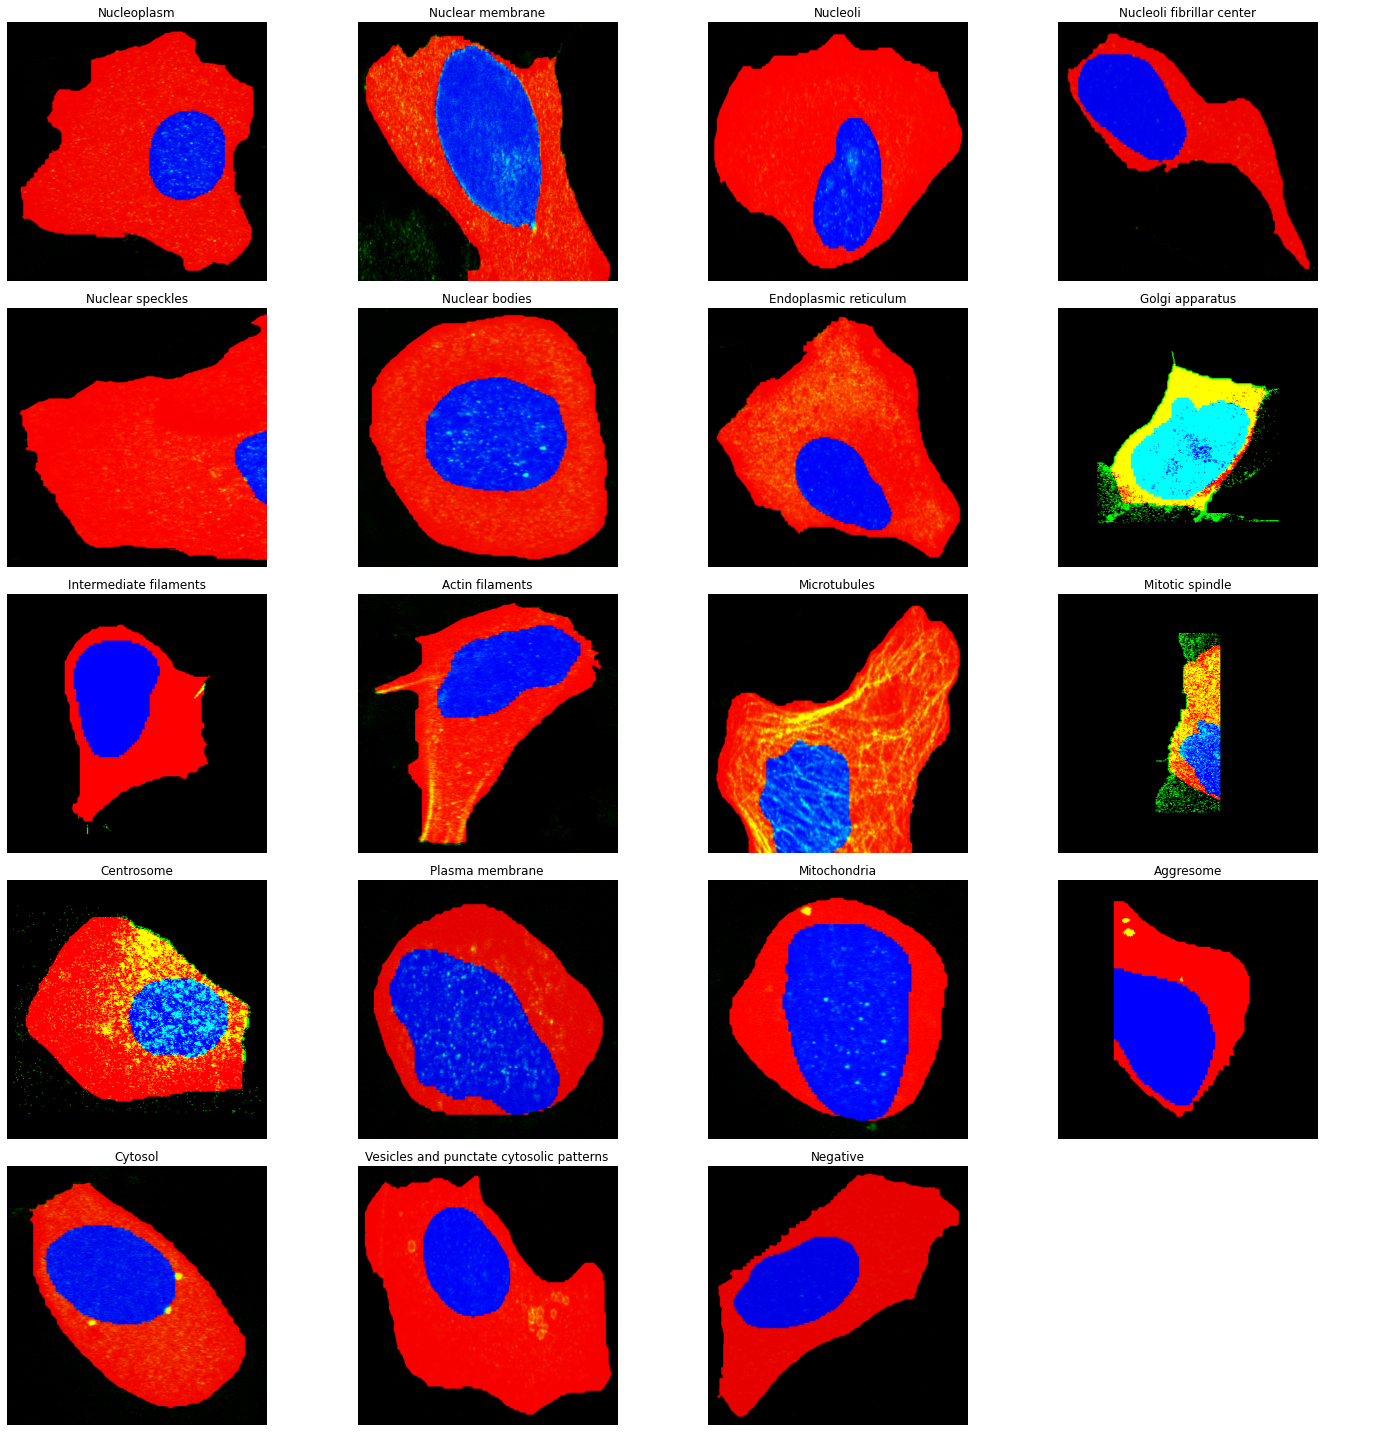

In [255]:
fig, axs = plt.subplots(5, 4)
for i, ax in enumerate([ax for axy in axs for ax in axy]):
#     ax = axs[i//3, i%3]
    if i<len(preview):
        ax.imshow(wiped_green_preview_resized[i])
        ax.set_title(classes[i])
    ax.grid(False)
    ax.axis(False)
plt.tight_layout()
plt.show()

# Saving all crops

In [12]:
df.values

array([['5e22a522-bb99-11e8-b2b9-ac1f6b6435d0', '0'],
       ['5f79a114-bb99-11e8-b2b9-ac1f6b6435d0', '14'],
       ['5c801c04-bb99-11e8-b2b9-ac1f6b6435d0', '14'],
       ...,
       ['dc261180-bbca-11e8-b2bc-ac1f6b6435d0', '6'],
       ['dd0989c4-bbca-11e8-b2bc-ac1f6b6435d0', '14'],
       ['df573730-bbca-11e8-b2bc-ac1f6b6435d0', '14']], dtype=object)